In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, 
                                                            postgres_host, postgres_port, postgres_db))
data = pd.read_sql_query('select * from houseprices', con=engine)
engine.dispose()

In [60]:
data.head()
data.yrsold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [61]:
# data.info()
data_number_col = data.select_dtypes(include=['int64', 'float64'])
data_object_col = data.select_dtypes(include=['object'])
# print(data_number_col.info())
# print(data_object_col.info())

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <a list of 10 Patch objects>)

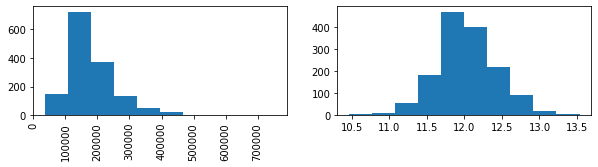

In [62]:
# explore the target variable 
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
target = data['saleprice']
plt.hist(target)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
target_log = np.log(data['saleprice'])
plt.hist(target_log)

# clearly, the logarithm target is closer to a normal distribution, therefore it should be used for the future analysis

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2       0.011378
bsmthalfbath     0.016844
miscval          0.021190
id               0.021917
lowqualfinsf     0.025606
yrsold           0.028923
overallcond      0.077856
mssubclass       0.084284
enclosedporch    0.128578
kitchenabvgr     0.135907
Name: salepr

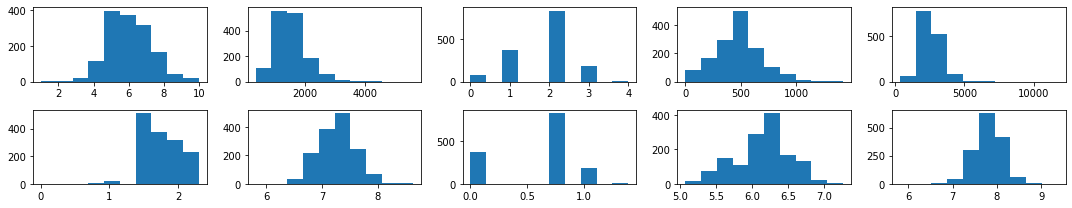

In [63]:
# explore the potential feature variables
# first the numerical variables

# data_number_col.columns
print(np.abs(data_number_col.corr().loc['saleprice'].sort_values(ascending=False)))

# for variables which showed a correlation with saleprice higher than 0.6 will be selected for furture process
data['totalsf'] = data['totalbsmtsf'] + data['firstflrsf'] + data['secondflrsf']

data[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf']]

plt.figure(figsize=(15,3))
plt.subplot(2,5,1)
plt.hist(data['overallqual'])
plt.subplot(2,5,2)
plt.hist(data['grlivarea'])
plt.subplot(2,5,3)
plt.hist(data['garagecars'])
plt.subplot(2,5,4)
plt.hist(data['garagearea'])
plt.subplot(2,5,5)
plt.hist(data['totalsf'])

plt.subplot(2,5,6)
plt.hist(np.log(data['overallqual']))
plt.subplot(2,5,7)
plt.hist(np.log(data['grlivarea']))
plt.subplot(2,5,8)
plt.hist(np.log(data[data['garagecars']>0]['garagecars']))
plt.subplot(2,5,9)
plt.hist(np.log(data[data['garagearea']>0]['garagearea']))
plt.subplot(2,5,10)
plt.hist(np.log(data['totalsf']))

plt.tight_layout()

In [64]:
# it seems the columns: grlivarea and totalbsmtsf become closer to a normal distribution than before
# so replace this two columns by logrithms columns

data['grlivarea'] = np.log(data['grlivarea'])
data['totalsf'] = np.log(data['totalsf'])

print(data['grlivarea'].mean())
print(data['totalsf'].mean())

7.267774383311004
7.802455132374678


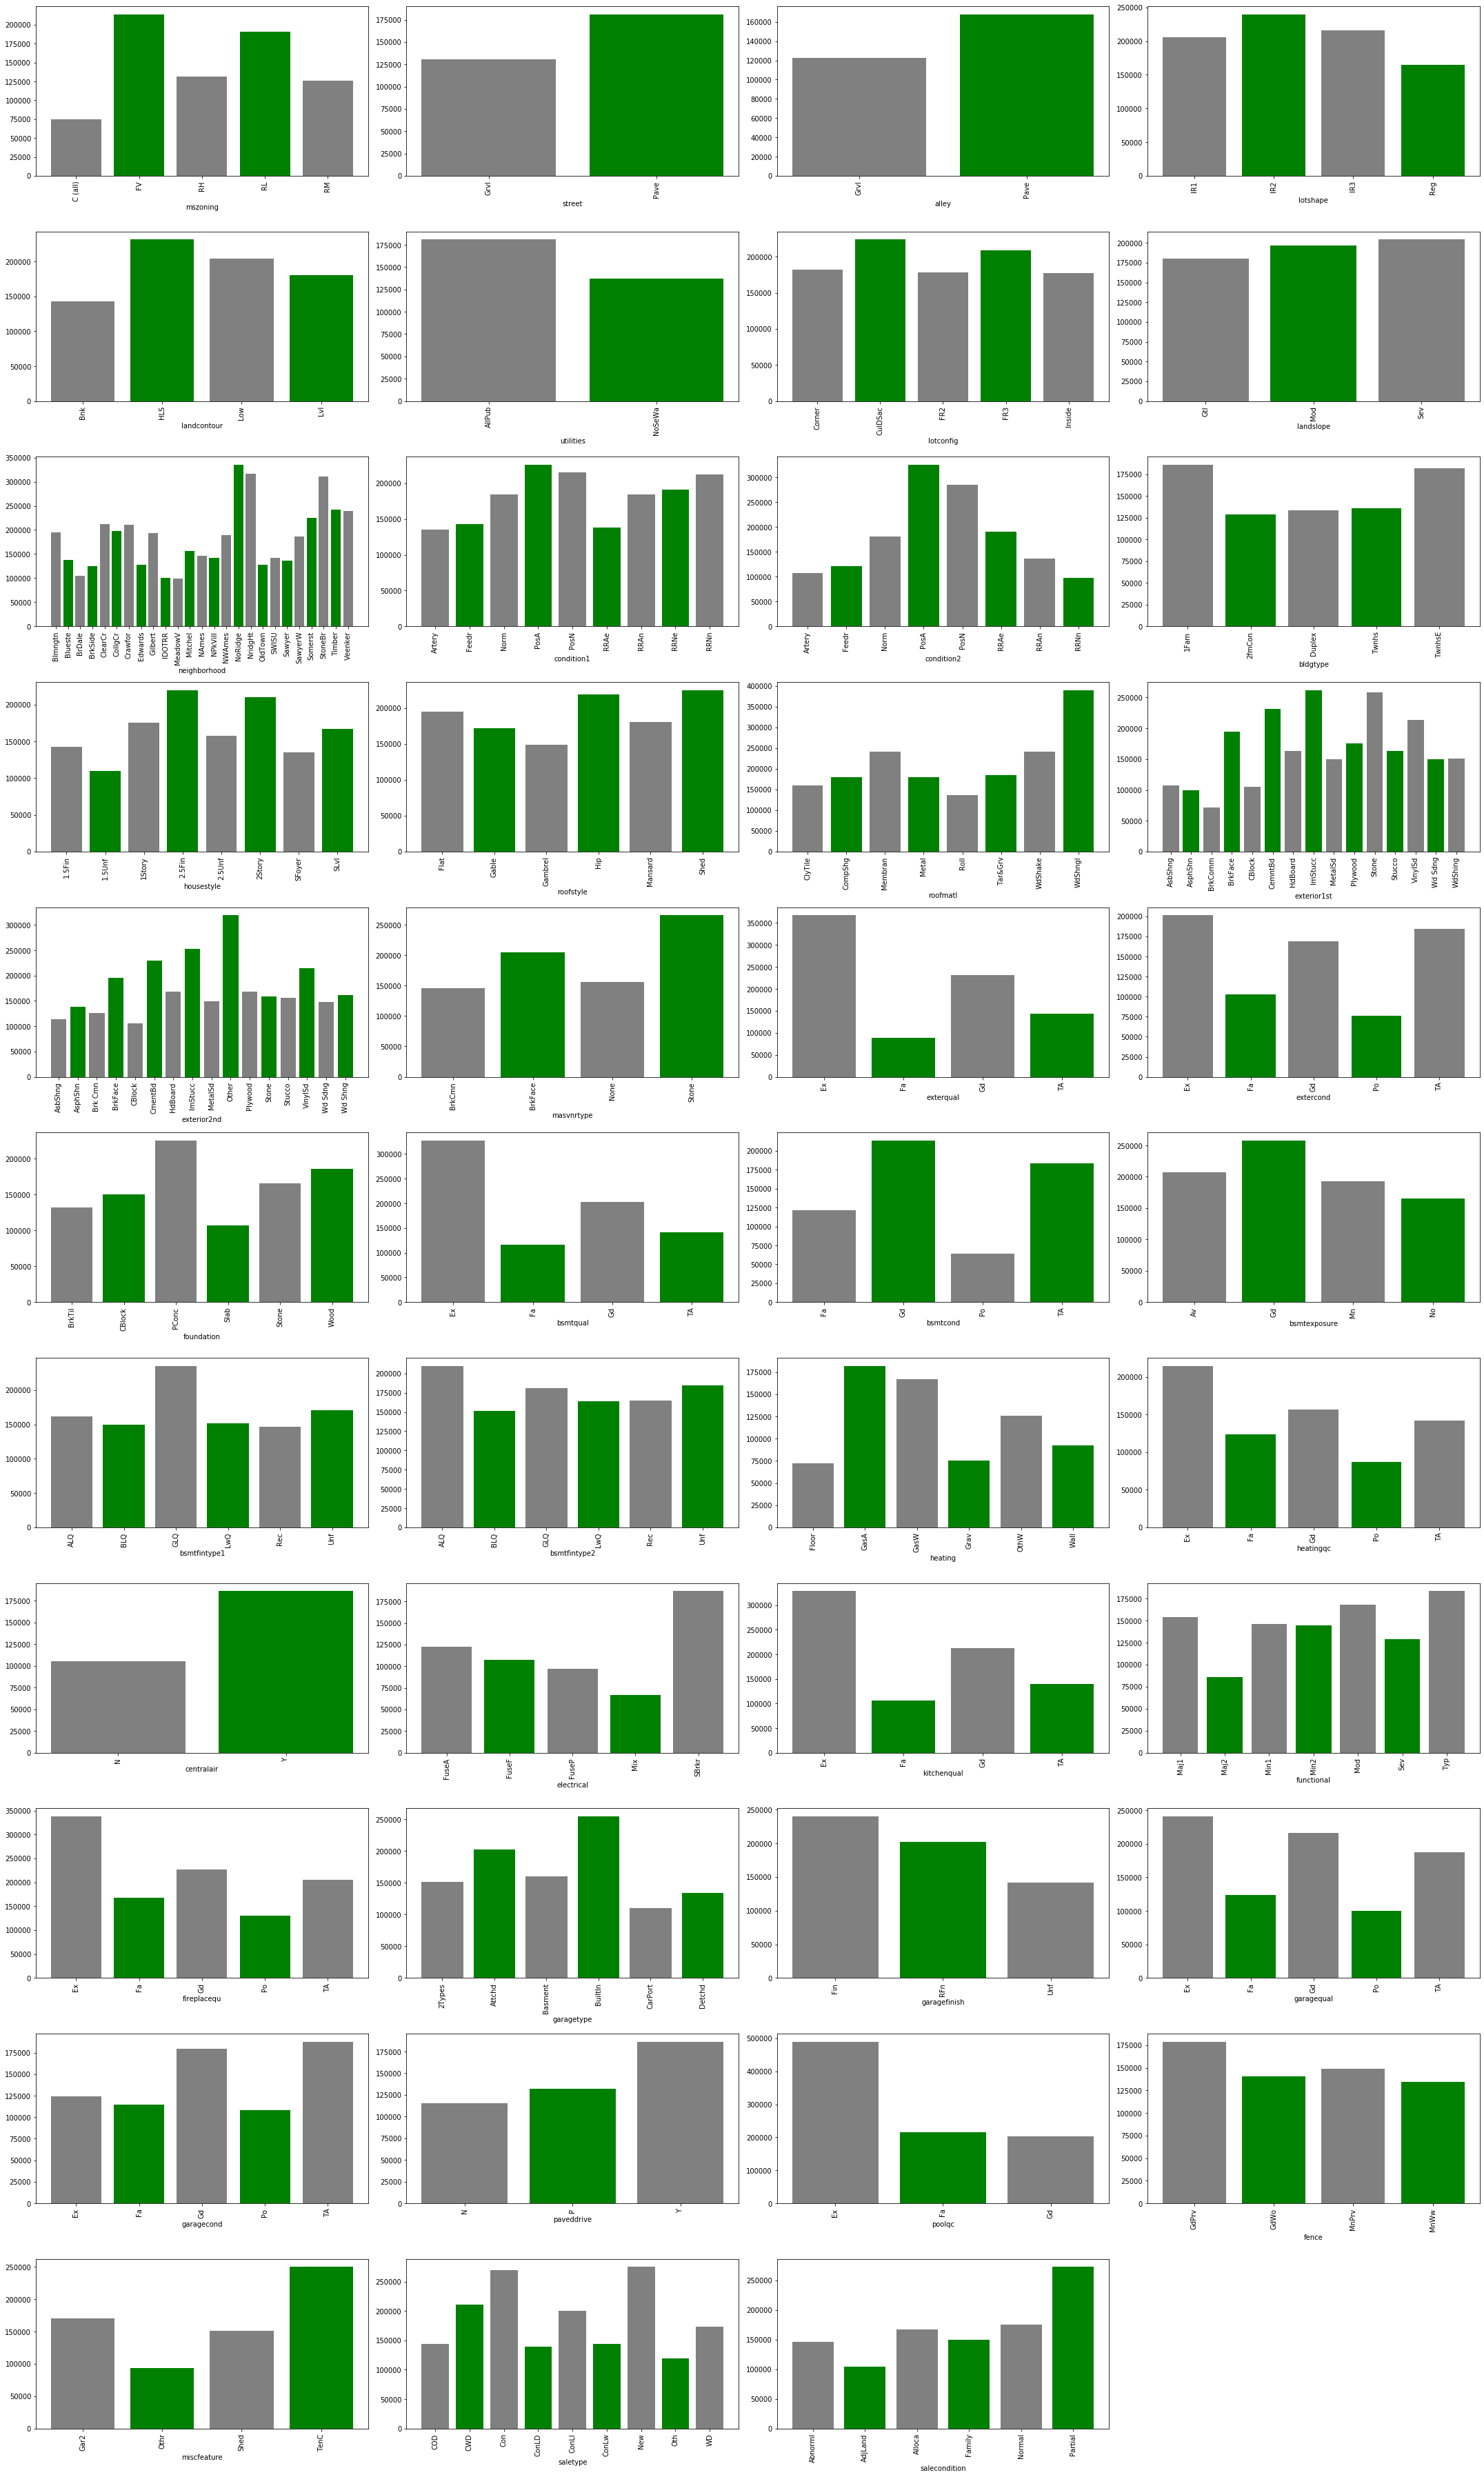

Index(['street', 'alley', 'centralair', 'garagefinish', 'paveddrive'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
street          1460 non-null object
alley           91 non-null object
centralair      1460 non-null object
garagefinish    1379 non-null object
paveddrive      1460 non-null object
dtypes: object(5)
memory usage: 57.1+ KB


In [65]:
cols = data_object_col.columns
# print(cols)
plt.figure(figsize=(30,50))
for i in range(0, len(cols)):
    plt.subplot(11,4,i+1)
    plt.bar(data.groupby(cols[i])['saleprice'].mean().index, data.groupby(cols[i])['saleprice'].mean(), color=('grey', 'green'))
    plt.xticks(rotation=90)
    plt.xlabel(cols[i])

plt.tight_layout()
plt.show()

print(cols[[1,2,28,34,37]])

data[cols[[1,2,28,34,37]]].info()

# columns which showed some kind of trend with saleprice will be selected for furture process
# however for the column: alley showed more 90% of missing or none values will be impossible for furture explore, so will be disgard
# so only cols[1,28,34,37] will be furture processed 

In [66]:
# fix the null values in the garagefinish column, replace the missing value by the value next to it

for i in range(0, len(data.yearbuilt)):
    if pd.isnull(data.garagefinish[i]):
        data.garagefinish[i] = data.garagefinish[i-1]

# data.info()

In [67]:
# now combine the selected numerical and object variables into one dataframe
# also the object variable need convert to dummies
df_numerical = data[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf']]
df_object = data[['street', 'centralair', 'garagefinish', 'paveddrive']]

df_object_dummy = pd.get_dummies(df_object)

df_combined = pd.concat([df_numerical, df_object_dummy], axis=1)
df_combined.dropna(how='any', inplace=True)
df_combined.columns
# df_combined
# why dropna does not work for 'totalbsmtsf'??????????????????????????????????????????????

Index(['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf',
       'street_Grvl', 'street_Pave', 'centralair_N', 'centralair_Y',
       'garagefinish_Fin', 'garagefinish_RFn', 'garagefinish_Unf',
       'paveddrive_N', 'paveddrive_P', 'paveddrive_Y'],
      dtype='object')

In [68]:
# now, use PCA to reduce the number of features 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

X = df_combined[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf',
       'street_Grvl', 'street_Pave', 'centralair_N', 'centralair_Y',
       'garagefinish_Fin', 'garagefinish_RFn', 'garagefinish_Unf',
       'paveddrive_N', 'paveddrive_P', 'paveddrive_Y']]
X = StandardScaler().fit_transform(X)
sklearn_pca = PCA(n_components=10)
pca_ = sklearn_pca.fit_transform(X)
print(sklearn_pca.explained_variance_ratio_)

df_pca = pd.DataFrame()
pca_1=[]
pca_2=[]
pca_3=[]
pca_4=[]
pca_5=[]
pca_6=[]
for i in pca_:
    pca_1.append(i[0])
    pca_2.append(i[1])
    pca_3.append(i[2])
    pca_4.append(i[3])
    pca_5.append(i[4])
    pca_6.append(i[5])
df_pca['pca_1'] = pca_1
df_pca['pca_2'] = pca_2
df_pca['pca_3'] = pca_3
df_pca['pca_4'] = pca_4
df_pca['pca_5'] = pca_5
df_pca['pca_6'] = pca_6

df_pca['saleprice'] = np.log(data['saleprice'])
df_pca.corr()

[0.30729843 0.14081781 0.13177942 0.09533401 0.09054923 0.07688244
 0.06549326 0.05220496 0.02381395 0.00881011]


,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,saleprice
pca_1,1.000000e+00,-1.987381e-17,5.942629e-17,5.055125e-17,-3.769231e-17,1.978899e-17,-0.867640
pca_2,-1.987381e-17,1.000000e+00,2.822822e-16,1.839837e-16,1.421590e-16,-4.891673e-17,0.165083
pca_3,5.942629e-17,2.822822e-16,1.000000e+00,1.249568e-16,1.607367e-16,4.784674e-19,-0.164775
pca_4,5.055125e-17,1.839837e-16,1.249568e-16,1.000000e+00,5.603913e-16,5.542484e-17,0.000482
pca_5,-3.769231e-17,1.421590e-16,1.607367e-16,5.603913e-16,1.000000e+00,-4.528971e-16,0.033811
pca_6,1.978899e-17,-4.891673e-17,4.784674e-19,5.542484e-17,-4.528971e-16,1.000000e+00,0.032370
saleprice,-8.676403e-01,1.650828e-01,-1.647746e-01,4.821459e-04,3.381107e-02,3.236979e-02,1.000000


In [69]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

feature = df_pca[['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']]
target = df_pca['saleprice']

x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=466)

lrm = linear_model.LinearRegression()
lrm.fit(x_train, y_train)
y_train_pred = lrm.predict(x_train)
y_test_pred = lrm.predict(x_test)

print(lrm.score(x_train, y_train))
print(lrm.score(x_test, y_test))

0.8098204507255947
0.8071843288856397


0.005588321352031402


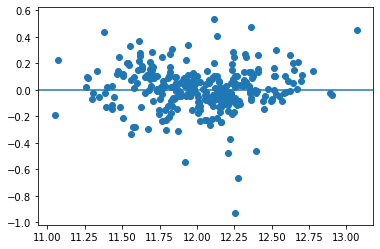

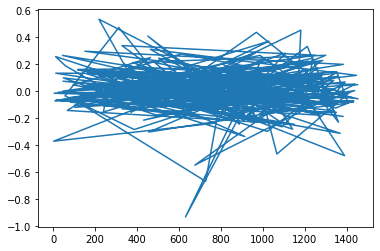

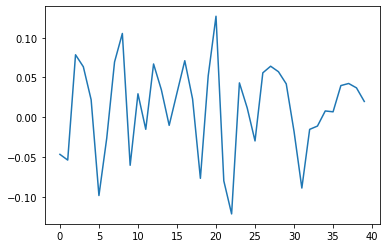

In [70]:
# checking the assumptions of linear regression

errors = y_test - y_test_pred
print(np.mean(errors))
# the mean of errors is close to 0

# homoscedasticity
plt.scatter(y_test_pred, errors)
plt.axhline(y=0)
plt.show()

# error terms should be uncorrelated with one another
plt.plot(errors)
plt.show()
# correlation between errors
from statsmodels.tsa.stattools import acf
acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.show()
# the correlation between errors are very small, so almost no correlation


In [71]:
# interpret estimated coefficients

import statsmodels.api as sm
feature = df_pca[['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']]
target = df_pca['saleprice']

Y = target
X = feature

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
print(results.summary())

# the pca_4 higher than 0.1 and it indicate statistically insignificant, 
# so can be removed without affection the predicting performance

# the F_statistics is 1035 and the associated prob is 0, which means our model add information to the 
# reduced model



                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     1028.
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:20:57   Log-Likelihood:                 478.65
No. Observations:                1460   AIC:                            -943.3
Df Residuals:                    1453   BIC:                            -906.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0241      0.005   2629.054      0.0

Mean absolute error of the prediction is: 0.12091211035058036
Mean squared error of the prediction is: 0.028303298087478397
Root mean squared error of the prediction is: 0.16823584067456732
Mean absolute percentage error of the prediction is: 1.0097243876265989


Text(0.5, 1, 'regular_price')

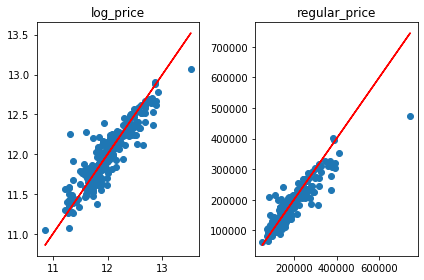

In [72]:
# after all the relavent test, it seems the model works well

plt.subplot(1,2,1)
plt.scatter(y_test, y_test_pred)
plt.plot(y_test, y_test, color='r')
plt.title('log_price')

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_pred)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_pred)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_pred)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100))

plt.subplot(1,2,2)
plt.scatter(np.exp(y_test), np.exp(y_test_pred))
plt.plot(np.exp(y_test), np.exp(y_test), color='r')
plt.tight_layout()
plt.title('regular_price')

In [73]:
# since our test model R_square is very similar to the test R_square, so it should not overfitting
# we will just try to practise the mothods

# first checking if the cross_val_score consistancy for different trian data set
linear_results = cross_val_score(lrm, x_train, y_train, cv=10)
print(np.var(linear_results))

# apply the ridge regression
ridge = linear_model.Ridge()
ridge_results = cross_val_score(ridge, x_train, y_train, cv=10)
print(np.var(ridge_results))

# apply the lasso regression
lasso = linear_model.Lasso()
lasso_results = cross_val_score(lasso, x_train, y_train, cv=10)
print(np.var(lasso_results))

# it seems the varance of the cross_val_score is very small, the fitting is consistancy over all 
# observations. Also after apply other regressions the varance of the cross_val_score do not improve
# significantly

0.0016830487572550706
0.0016808603615689726
0.00013601410625698206


## Modification

##### Adding interest rate and stock price into the dataset

In [105]:
import warnings
warnings.simplefilter(action='ignore')

data['rate'] = 0
data.rate[data.yrsold == 2006] = 0.07938
data.rate[data.yrsold == 2007] = 0.08083
data.rate[data.yrsold == 2008] = 0.05063
data.rate[data.yrsold == 2009] = 0.0325
data.rate[data.yrsold == 2010] = 0.0324

data['stock'] = 1
data.stock[data.yrsold == 2006] = 12463
data.stock[data.yrsold == 2007] = 13264
data.stock[data.yrsold == 2008] = 8776
data.stock[data.yrsold == 2009] = 10428
data.stock[data.yrsold == 2010] = 11577

# data.head()

In [102]:
new_feature = pd.concat([df_pca[['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']], data[['rate', 'stock']]], axis=1)
target = df_pca['saleprice']

Y = target
X = new_feature

X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     771.1
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:35:24   Log-Likelihood:                 479.31
No. Observations:                1460   AIC:                            -940.6
Df Residuals:                    1451   BIC:                            -893.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0213      0.034    350.014      0.0

##### By adding the new features into the model, the accuracy does not improve, so it is not worth to include the two new feature into the model. Also, the p_value showed the coef of the two new feature is not significant.